In [1]:
from src import SQL_Executor, SQL_Queries
import pandas as pd
import numpy as np

executor = SQL_Executor()
query = SQL_Queries().Vintage()
df1 = executor.execute_query(query.q1())
df2 = executor.execute_query(query.q2())
df1

ImportError: cannot import name 'Self' from 'typing' (C:\Users\karci\.pyenv\pyenv-win\versions\3.10.11\lib\typing.py)

In [ ]:
df1 = df1.sort_values("transaction_date")
df1["transaction_date"] = pd.to_datetime(df1["transaction_date"])
df1["first_month"] = df1["transaction_date"].dt.to_period("M")
df1 = df1.drop(columns=["transaction_date"])
df1 = df1.groupby("user_id").first().reset_index()

df1

,user_id,transaction_id,first_month
0,1,19,2022-01
1,2,29,2022-01
2,3,9,2022-01
3,4,4,2022-01
4,5,39,2022-01
...,...,...,...
18807,22191,44214,2024-11
18808,22192,44614,2024-11
18809,22193,44215,2024-11
18810,22195,44616,2024-11


In [ ]:
df3 = df1.merge(df2, how="left", on="transaction_id")

scheduled_date = pd.to_datetime(df3["scheduled_date"])
payment_date = pd.to_datetime(df3["payment_date"])
today = pd.Timestamp.today()

conditions = [
    payment_date > scheduled_date,
    payment_date.isna(),
    payment_date <= scheduled_date,
]

choices = [
    (payment_date - scheduled_date).dt.days,
    np.maximum((today - scheduled_date).dt.days, 0),
    0,
]

df3["dpd"] = np.select(conditions, choices, default=0)
df3 = df3.drop(columns=["payment_date", "scheduled_date"])

df3["dpd90"] = (df3["dpd"] >= 90).astype(int)
df3 = (
    df3.groupby(["first_month", "user_id", "installment_number"])["dpd90"]
    .max()
    .reset_index()
)
df3 = df3.groupby(["first_month", "installment_number"])["dpd90"].mean().reset_index()


df3["dpd90_pct"] = df3["dpd90"] * 100

df3

,first_month,installment_number,dpd90,dpd90_pct
0,2022-01,1,0.088435,8.843537
1,2022-01,2,0.068027,6.802721
2,2022-01,3,0.115646,11.564626
3,2022-01,4,0.098639,9.863946
4,2022-01,5,0.132075,13.207547
...,...,...,...,...
787,2024-11,20,0.000000,0.000000
788,2024-11,21,0.000000,0.000000
789,2024-11,22,0.000000,0.000000
790,2024-11,23,0.000000,0.000000


<Axes: xlabel='installment_number'>

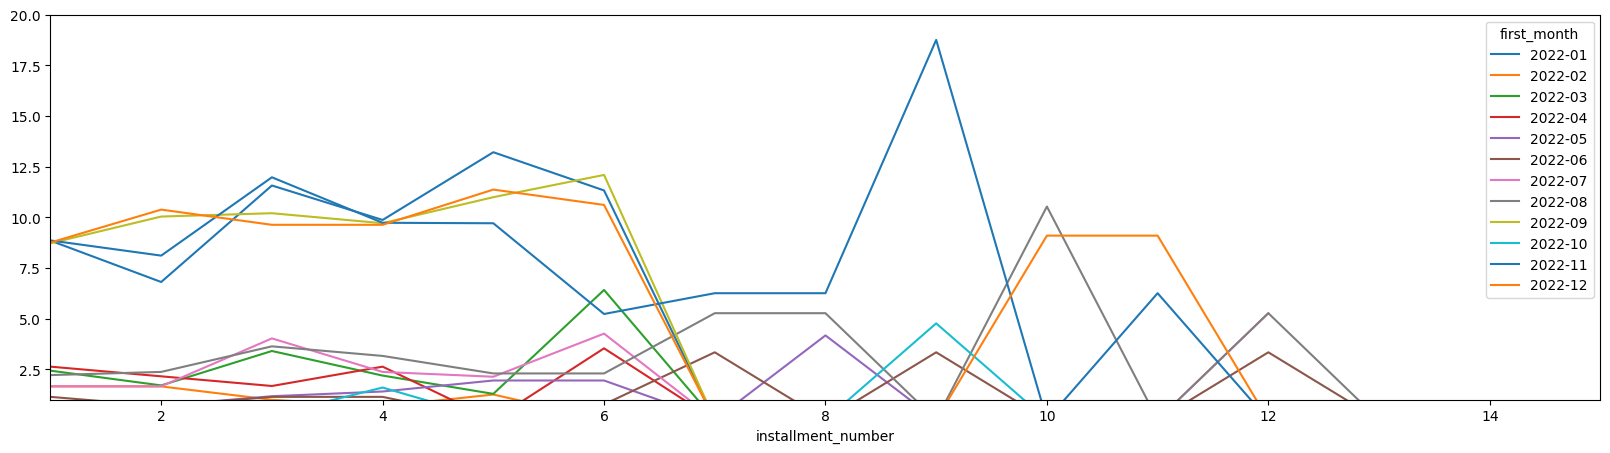

In [ ]:
dpd1 = df3[df3["first_month"].astype(str).str[:4] == "2022"]

dpd1.pivot(index="installment_number", columns="first_month", values="dpd90_pct").plot(
    kind="line", ylim=(1, 20), xlim=(1, 15), figsize=(20, 5)
)